# 常规赛：黄斑中央凹定位（GAMMA挑战赛任务二）

## 赛题介绍
### 一、赛题背景
> 除了视盘，眼底另一重要结构是黄斑。黄斑在视盘的颞侧0.35cm处并稍下方，处于人眼的光学中心区。黄斑中央的凹陷称为**中央凹**，是**视力最敏锐的地方**。因此，实现中央凹的精确定位对眼底疾病自动化诊断至关重要。
### 二、比赛链接
> https://aistudio.baidu.com/aistudio/competition/detail/120/0/introduction
### 三、赛题任务
> 根据给定眼底图像彩照，预测中央凹在图像中的坐标值(十字中心坐标)。下图为模型预测结果。
![](https://ai-studio-static-online.cdn.bcebos.com/08a2edaa9c1e4fcda20e393e4dcdc6b8eb14274823f94df78641bb66c5f28275)
![](https://ai-studio-static-online.cdn.bcebos.com/7299c500ba2e47078448f2f210a0725813752d40177341e59a8052f2edfc5167)

### 四、数据说明
> 本常规赛数据集由中国广州中山大学中山眼科中心提供，数据集中包含200个2D眼底彩照样本，分别为：训练集100个，测试集100个。

> 常规赛训练集
训练数据集包括100个样本0001-0100，每个样本对应一个2D眼底彩照数据，存储为0001.jpg。黄斑中央凹定位坐标金标准存储在Excel表格中，第一列为图像名称，第二列为x坐标位置，第三列为y坐标位置。
![](https://ai-studio-static-online.cdn.bcebos.com/e65801e824ae466c9457008623e7f42e63723814234c4a0fa263ca5358517ce3)

### 五、评价指标
>评价指标Evaluation Metrics

>平均欧式距离(Average Euclidean Distance, AED)是黄斑中央凹定位结果的评价指标，计算每个测试样本预测的黄斑中央凹坐标与金标准的欧式距离（坐标被归一化），最终计算其平均值。该任务的最后得分即为平均欧式距离的倒数：
![](https://ai-studio-static-online.cdn.bcebos.com/49942e3fc42948bba7b5f626963375a8c14ab8b60293457499f5ddcba1bb5048)




### 六、比赛思路
>1. 通过将所有图片翻转为视盘在左，尺寸reshape为1956x1934，在对中央凹的坐标值进行统计分析，发现中央凹位置集中在（608，400）的范围内。因此，对于每张图片，只将关注范围移动到此区域。

>2. 由于使用resnet接fc层直接进行坐标回归缺乏空间泛化能力，因此本项目采用Unet结合heatmap的方式进行精确定位。可参考https://zhuanlan.zhihu.com/p/374842773

>3. 为了更准确地评价模型，采用了5折交叉验证分别训练5个模型，为了确保每个训练数据对最终模型的预测都做出贡献，取这5个模型的平均作为预测结果。

>4. 通过提高热力图的最大值(10)，提升了模型的收敛速度；在损失函数里添加了模型输出的方差奖励，奖励模型输出比较集中在一个区域。


## 模型效果展示
>左边对应模型预测的热力图，右侧对应原图和十字中央凹位置。可以看到模型输出的热力图集中在中央凹附近。

![](https://ai-studio-static-online.cdn.bcebos.com/5244ec98e2c94925adeb1a7cc59bab3c37637d2a52fe4102b9df6b330656f6cf)
![](https://ai-studio-static-online.cdn.bcebos.com/ddedb6ae53724ef597f9b8c3769f6a1cbd0296512e234c65bd81c216fa53faf4)
![](https://ai-studio-static-online.cdn.bcebos.com/3e2900c8c22e4b718731547dd90ef8a271731dd089464fc2ba81d92bfa77d58b)
![](https://ai-studio-static-online.cdn.bcebos.com/c5de00c96810404f95937c2f65d0367caf35d902b37c4345b43eeb77ad22073d)


### 获取数据集，解压数据，获取预训练模型，代码包

In [ ]:
#获取数据集
!wget https://dataset-bj.cdn.bcebos.com/%E5%8C%BB%E7%96%97%E6%AF%94%E8%B5%9B/task2_Fovea_localization.zip

#解压数据集到/data文件夹
!unzip -oq task2_Fovea_localization.zip -d ./data

#解压已经炼好的模型，大家可以在此基础上再继续精炼
import os
os.mkdir('./model')
!unzip -oq data/data120091/炼好的模型.zip -d ./model

## 代码部分

### 一、导入基本模块

In [1]:
#导入相关包，函数
from work.my_func.data_process import transfer_img_location,get_gauss_map,dark_kernel_process
from work.my_func.data_info import train_lr,train_size,test_lr,test_size,get_img_path
from work.my_func.model import Unet

import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset,DataLoader
from paddle.nn import Linear,Dropout,BatchNorm1D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
from PIL import Image

# 忽略警告输出
warnings.filterwarnings("ignore")
paddle.set_device('gpu')
paddle.disable_static()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


### 二、数据分析

x的波动范围：487.3958480000001
y的波动范围：282.36016400000017
x的中值：1139.385184
y的中值：1038.351979
中央凹分布如下


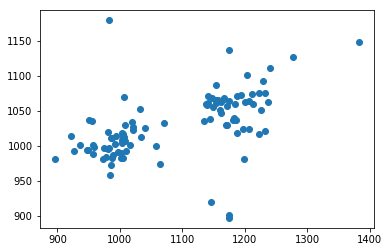

In [5]:
#接收转换后的位置
transfer_location_x = []
transfer_location_y = []

#遍历训练数据
for index in range(100):
    _,location = transfer_img_location(index,lr=train_lr[index],size=train_size[index],mode='train')
    transfer_location_x.append(location[0])
    transfer_location_y.append(location[1])

#分析结果
print('x的波动范围：{}'.format(np.max(transfer_location_x) - np.min(transfer_location_x)))
print('y的波动范围：{}'.format(np.max(transfer_location_y) - np.min(transfer_location_y)))
print('x的中值：{}'.format((np.max(transfer_location_x) + np.min(transfer_location_x))/2))
print('y的中值：{}'.format((np.max(transfer_location_y) + np.min(transfer_location_y))/2))
print('中央凹分布如下')

plt.scatter(transfer_location_x,transfer_location_y)
plt.show()

### 三、构建训练数据集

In [2]:
#列表乱序，随机切分数据集
random.seed(1024)
all_data = [i for i in range(100)]
random.shuffle(all_data)

class TrainData(Dataset):
    def __init__(self,fold_num):        #传入折数，1,2,3,4,5其中一个
        super(TrainData,self).__init__()
        self.num_samples = 80
        self.fold_num = fold_num
        self.sample_list = list(set(all_data) - set(all_data[(self.fold_num-1)*20:(self.fold_num-1)*20+20]))    #获取训练数据样本id

    def __getitem__(self, index):
        #读取图片和标签
        index = self.sample_list[index]
        img,location = transfer_img_location(index,lr=train_lr[index],size=train_size[index],mode='train')  #加载图片，位置

        #以中央凹为中心，对图片做随即平移，防止网络只输出一个常量
        #由于在训练时，每次看到的图片都不一样（平移量不一样），所以训练的epoch要多一点100或200轮
        x,y = location
        x,y = int(x),int(y)
        move_x = random.randint(-240,240)
        move_y = random.randint(-180,180)
        x = x + move_x
        y = y + move_y
        img = img[:,x-304:x+304,y-200:y+200]

        #转换输出类型为np.array,'float32'
        features = np.array(img).astype('float32')
        labels = np.array(get_gauss_map((304-move_x,200-move_y),sigma=1,r=80)).astype('float32') #标签是热力图的形式
        return features,labels

    def __len__(self):
        return self.num_samples

### 四、定义模型评估方法

In [3]:
#epoch:训练轮次，方便模型命名
#train_size:计算归一化欧式距离
#model:评估的模型
#fold_num:与训练数据集相对应，使用剩下的20个样本进行评估
#visual_avalible:是否可视化模型输出与输入图片，默认为False
def evaluation(epoch,train_size,model,fold_num,visual_avalible=False): 

    model.eval()
    ED = 0      #归一化欧氏距离
    valid_sample = all_data[(fold_num-1)*20:(fold_num-1)*20+20]

    for index in valid_sample:
        #加载数据，标签
        img,location = transfer_img_location(index,lr=train_lr[index],size=train_size[index],mode='train')
        img = img[:,836:1444,840:1240]
        features = np.array(img).astype('float32')
        labels = np.array(get_gauss_map(location)).astype('float32')

        #模型预测
        features = paddle.to_tensor([features])
        pre = model(features)[0].numpy()
        
        #由于模型极少情况下预测的热力图是空白，因此分类讨论输出
        if np.sum(pre) < 1000:
            pre_x,pre_y = 304+80,200+40
        else:
            pre_x,pre_y = dark_kernel_process(pre[0])  #效果最好

        #计算ED
        x,y = np.array(location) - np.array([836,840])
        if train_size[index] == 1:
            ED = ED + (((pre_x - x)/2992)**2 + ((pre_y - y)/2000)**2)**(1/2)
        else:
            ED = ED + (((pre_x - x)/1956)**2 + ((pre_y - y)/1934)**2)**(1/2)

        #可视化模型输出与输入图片
        if visual_avalible:
            print('第{}张图片'.format(index+1))
            plt.subplot(121)
            plt.imshow(pre[0].transpose(1,0))
            plt.subplot(122)
            plt.imshow(img.transpose(2,1,0))
            plt.show()

    ED = ED / 20
    print('epoch:{},ED:{}'.format(epoch,ED))
    #对效果较好的模型进行保存
    if ED < 0.009:
        paddle.save(model.state_dict(), 'model/model{}_ED{}.pdparams'.format(fold_num,ED)) #保存模型参数

    model.train()

### 五、定义动态图训练过程

In [4]:
#传入三个参数model,opt,fold_num
#建议使用GPU32G环境运送此项目
def train(model,opt,fold_num,EPOCH_NUM=200,visual_avalible=False):    #加载预训练模型再训练时，可将此处设置为100
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')
    model.train()

    for epoch_id in range(EPOCH_NUM):
        for batch_id,data in enumerate(train_loader()):
            #读取数据
            features,labels = data
            features = paddle.to_tensor(features)
            labels = paddle.to_tensor(labels)

            #前向传播
            predicts = model(features)

            #使用均方误差，同时增加了对模型方差的控制，希望模型的预测热力图能集中在一个区域，因此需要增加方差，在代价函数中采用-0.0005的系数
            loss = F.square_error_cost(predicts,labels) - 0.0005 * paddle.var(predicts)

            #反向传播
            avg_loss = paddle.mean(loss)
            avg_loss.backward()

            #更新参数
            opt.step()

            #变量梯度清0
            opt.clear_grad()

            #打印损失
            if batch_id % 3 == 0:
                print('epoch_id:{},loss:{}'.format(epoch_id,avg_loss.numpy()))
        
        evaluation(epoch_id,train_size,model,fold_num,visual_avalible=visual_avalible)  #需要可视化时，添加visual_avalible=True

### 六、训练模型并保存

In [ ]:
'''
由于训练每个模型需要20G以上显存，因此训练好一个模型以后，请重启内核再训练下一个模型，防止显存溢出。
'''
#加载模型
model = Unet()

#加载预训练模型，预训练模型是在100个样本上进行的训练
layer_state_dict = paddle.load("model/model_epoch101_batch12_loss[0.46564353].pdparams")
model.set_state_dict(layer_state_dict)

#定义优化器
opt = paddle.optimizer.Adam(learning_rate=5e-4,parameters=model.parameters(),weight_decay=paddle.regularizer.L2Decay(coeff=0.001))

#定义fold_num,从1到5共训练五个模型
fold_num = 1    
train_data = TrainData(fold_num)        
train_loader = DataLoader(train_data,batch_size=10,shuffle=True,drop_last=False)    #batch_size不要过大

#模型训练
train(model,opt,fold_num,EPOCH_NUM=10,visual_avalible=False)

### 七、加载全部模型进行预测并提交结果

In [2]:
#加载模型
model1 = Unet()
model1.set_state_dict(paddle.load("model/model1_ED0.008243825249706058.pdparams"))
model1.eval()

model2 = Unet()
model2.set_state_dict(paddle.load("model/model2_ED0.00708214607276843.pdparams"))
model2.eval()

model3 = Unet()
model3.set_state_dict(paddle.load("model/model3_ED0.008693393679250788.pdparams"))
model3.eval()

model4 = Unet()
model4.set_state_dict(paddle.load("model/model4_ED0.00877534777237888.pdparams"))
model4.eval()

model5 = Unet()
model5.set_state_dict(paddle.load("model/model5_ED0.007696413964666473.pdparams"))
model5.eval()
model_list = [model1,model2,model3,model4,model5]

#生成预测结果
predict_list = []

print('解算开始...')
for index in range(100):
    #载入测试数据
    img,location = transfer_img_location(index,lr=test_lr[index],size=test_size[index],mode='test')
    img = img[:,836:1444,840:1240]
    features = np.array(img).astype('float32')
    labels = np.array(get_gauss_map(location)).astype('float32')
    features = paddle.to_tensor([features])


    '''
    这里的方法是对每个热力图做黑核搜索然后将坐标平均；另一种做法是先对热力图做平均，在对其使用黑核搜索（推荐尝试）
    '''
    PreX,PreY = 0,0
    for model in model_list:
        pre = model(features)[0].numpy()
        if np.sum(pre) < 1000:
            pre_x,pre_y = 304+80,200+40
        else:
            pre_x,pre_y = dark_kernel_process(pre[0],kernel_size=80)  #使用黑核搜索将热力图转为标签
        PreX = pre_x + PreX
        PreY = pre_y + PreY
    PreX = PreX / 5
    PreY = PreY / 5

    PreX = PreX + 1140-304
    PreY = PreY + 1040-200
    if test_lr[index] == 1:
        PreX = 1956 -PreX

    if test_size[index] == 1:
        PreX = PreX + 518
        PreY = PreY + 33

    print('图片：{}，预测结果：{}'.format(index+101,[PreX,PreY]))
    predict_list.append([PreX,PreY])

print('解算完毕！')


#生成csv文件
pre_list = []
for index in range(100):
    pre_list.append([index+101] + predict_list[index])

dataframe = pd.DataFrame(pre_list)
dataframe.columns=['data','Fovea_X','Fovea_Y']
#最高得分9.07791
dataframe.to_csv('pre{}.csv'.format(3),sep=',',index=False)  #format里自设数字，区分开提交的版本即可

W1208 23:56:22.475440  6042 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1208 23:56:22.481185  6042 device_context.cc:465] device: 0, cuDNN Version: 7.6.


解算开始...
图片：101，预测结果：[1508.0, 1040.6]
图片：102，预测结果：[1476.0, 1045.4]
图片：103，预测结果：[1467.2, 1061.8]
图片：104，预测结果：[1470.8, 1019.0]
图片：105，预测结果：[1690.8, 1078.2]
图片：106，预测结果：[1693.2, 1083.4]
图片：107，预测结果：[726.4000000000001, 1015.5999999999999]
图片：108，预测结果：[1494.8, 1057.0]
图片：109，预测结果：[1687.2, 1095.4]
图片：110，预测结果：[1446.0, 1080.2]
图片：111，预测结果：[1674.0, 1085.8]
图片：112，预测结果：[1472.0, 1037.0]
图片：113，预测结果：[1442.8, 1097.4]
图片：114，预测结果：[1451.6, 1011.4000000000001]
图片：115，预测结果：[1468.0, 1033.4]
图片：116，预测结果：[1246.4, 1103.8]
图片：117，预测结果：[680.4000000000001, 999.2]
图片：118，预测结果：[1489.2, 1035.0]
图片：119，预测结果：[1692.8, 1090.2]
图片：120，预测结果：[1683.6, 1102.6]
图片：121，预测结果：[1463.2, 1051.4]
图片：122，预测结果：[1260.4, 1100.6]
图片：123，预测结果：[1488.8, 1033.0]
图片：124，预测结果：[1467.2, 1038.2]
图片：125，预测结果：[1690.8, 1063.4]
图片：126，预测结果：[1257.2, 1121.4]
图片：127，预测结果：[1288.4, 1205.8]
图片：128，预测结果：[1389.2, 1034.2]
图片：129，预测结果：[1532.0, 1056.6]
图片：130，预测结果：[1476.0, 1052.2]
图片：131，预测结果：[1496.0, 1008.2]
图片：132，预测结果：[1466.4, 1072.6]
图片：133，预测结果：[1483.2

## 总结与思考
>1. 本项目使用Unet网络结合heatmap回归的方式成功的进行了中央凹位置的精确定位。为了提升项目骨干流程运行体验，项目中使用的辅助函数及Unet模型均放在work/my_func包下，其中Unet模型网络搭建与详解可参考
https://www.bilibili.com/video/BV11341127iK?from=search&seid=7756321337770355213&spm_id_from=333.337.0.0。
虽然是pytorch写的，但是用paddle重写真的很方便！

>2. 使用5个网络平均在训练数据集上进行评测将得到几乎ED0.007的好结果，但是提交预测的结果则在0.01，因此可以尝试增强模型正则，如增加L2惩罚，加大Unet网络dropout比率等。

>3. 另一个重要的可以提分的点是突破眼底图像较黑的数据，对这种图片的预测一般像素差能达到横纵坐标50，50左右，还是非常影响最终得分的。

>4. 使用飞桨参加比赛真的提高了我的动手能力，亲身实践过诸多的模型之后，最终才能够筛选出真正适用于赛题的那一个。

>5. 最后，带点私货，开题好难啊呜呜